In [40]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from sklearn import datasets
import tensorflow as tf

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchsummary import summary

import time
from alive_progress import alive_bar

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Classical data

In [41]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.label = label
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, self.label

In [42]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", transform=transform, label = 0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for element in dataloader:
   print(element)

[tensor([[[[0.0000, 0.0000, 0.0000, 0.7500, 0.9375, 0.2500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4375, 0.5625, 0.5000, 0.9375, 0.0000, 0.0000],
          [0.0000, 0.1250, 0.7500, 0.0000, 0.0000, 0.5625, 0.2500, 0.0000],
          [0.0000, 0.3125, 0.6875, 0.0000, 0.0000, 0.2500, 0.5000, 0.0000],
          [0.0000, 0.5000, 0.2500, 0.0000, 0.0000, 0.5000, 0.3750, 0.0000],
          [0.0000, 0.1250, 0.7500, 0.0000, 0.0625, 0.8750, 0.3125, 0.0000],
          [0.0000, 0.0000, 0.8125, 0.9375, 1.0000, 0.7500, 0.0625, 0.0000],
          [0.0000, 0.0000, 0.1250, 0.6250, 0.7500, 0.0625, 0.0000, 0.0000]]]]), tensor([0])]
[tensor([[[[0.0000, 0.0000, 0.0000, 0.6250, 0.7500, 0.1250, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6875, 1.0000, 1.0000, 0.6250, 0.0000, 0.0000],
          [0.0000, 0.1875, 1.0000, 0.3125, 0.3750, 0.7500, 0.1250, 0.0000],
          [0.0000, 0.3125, 0.7500, 0.0000, 0.0000, 0.3750, 0.5000, 0.0000],
          [0.0000, 0.2500, 1.0000, 0.0000, 0.0000, 0.3750, 0.5000, 0.

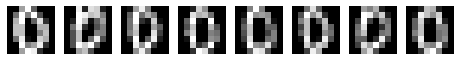

In [43]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show()

In [66]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

In [67]:
def resize_data(x, y, label, image_size):

    arr = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            arr.append((t, l))
    return arr

rd = resize_data(x_train, y_train, label = (0, ), image_size = 8)
#rd

In [68]:
dataloader1 = torch.utils.data.DataLoader(rd, batch_size=batch_size, shuffle=True, drop_last=True)

#for element in dataloader1:
#   print(element)

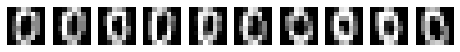

In [47]:
plt.figure(figsize=(8,2))

for i in range(10):
    image = rd[i][0].reshape(image_size,image_size)
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show() 

### Generator Network

In [48]:
device = torch.device("cpu")

In [49]:
# class Generator(nn.Module):

#     def __init__(self, z_dim):

#         super(Generator, self).__init__()
#         self.z_dim = z_dim
#         #self.gen_init_layer_size = gen_init_layer_size

#         self.convt_1 = nn.ConvTranspose2d(self.z_dim, 16 * 8, 2, 1, 0, bias=False)
#         self.batch_norm_1 = nn.BatchNorm2d(16 * 8)
#         self.relu_1 = nn.ReLU(True)
#         self.convt_2 = nn.ConvTranspose2d(16 * 8, 16 * 4, 2, 2, 0, bias=False)
#         self.batch_norm_2 = nn.BatchNorm2d(16 * 4)
#         self.relu_2 = nn.ReLU(True)
#         self.convt_3 = nn.ConvTranspose2d(16 * 4, 1, 2, 2, 0, bias=False)                                    

#     def forward(self, x):

#         x = self.convt_1(x)        
#         x = self.batch_norm_1(x)
#         x = self.relu_1(x)
#         print(x.shape)
#         # state size. (ngf*8) x 4 x 4
#         x = self.convt_2(x)
#         x = self.batch_norm_2(x)
#         x = self.relu_2(x)
#         print(x.shape)
#         x = self.convt_3(x)
#         print(x.shape)
        
#         return x

In [50]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.dense_layer = nn.Linear(self.z_dim, 64)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [72]:
z_dim = 100
batch_size = 3
gen_init_layer_size = 2*2*16
ngf = 8

input = torch.rand(1, z_dim) 
gen = Generator(z_dim)
test_images = gen(input).view(1,1,8,8).detach()


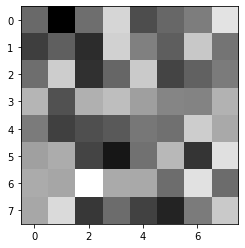

In [52]:
images = torch.squeeze(test_images, dim=1)
for j, im in enumerate(images):
    plt.imshow(im.numpy(), cmap="gray")
    
plt.show()

In [76]:
summary(gen, input_size=(1, z_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           6,464
           Sigmoid-2                [-1, 1, 64]               0
Total params: 6,464
Trainable params: 6,464
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Discriminator Network

In [77]:
class Discriminator(nn.Module):

    def __init__(self, image_size):
        super().__init__()

        self.image_size = image_size

        self.model = nn.Sequential(
                                    # Inputs to first hidden layer (num_input_features -> 64)
                                    nn.Linear(self.image_size * self.image_size, 64),
                                    nn.ReLU(),
                                    # First hidden layer (64 -> 16)
                                    nn.Linear(64, 16),
                                    nn.ReLU(),
                                    # Second hidden layer (16 -> output)
                                    nn.Linear(16, 1),
                                    nn.Sigmoid(),
                                    )

    def forward(self, x):
        return self.model(x)

In [91]:
# Testing discriminator network

real_data = rd[0][0]
fake_data = test_images

disc = Discriminator(image_size = 8)

#outD_real = disc(real_data).view(-1)
#outD_fake = disc(fake_data).view(-1)
disc

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [92]:
summary(disc, input_size=(64))

TypeError: 'int' object is not iterable

### Training class

In [63]:
class GAN():
    def __init__(self, dataloader, gen_net, disc_net, z_dim, image_size, batch_size, lrG, lrD, gen_loss, disc_loss):

        self.dataloader = dataloader
        self.gen_net = gen_net
        self.disc_net = disc_net
        self.z_dim = z_dim
        self.image_size = image_size
        self.batch_size = batch_size
        self.lrG = lrG
        self.lrD = lrD
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

        # Optimisers
        self.optD = optim.SGD(self.disc_net.parameters(), lr=self.lrD)
        self.optG = optim.SGD(self.gen_net.parameters(), lr=self.lrG)

        self.real_labels = torch.full((self.batch_size,), 1.0, dtype=torch.float, device=device)
        self.fake_labels = torch.full((self.batch_size,), 0.0, dtype=torch.float, device=device)        

        # Collect images for plotting later        

    def generated_and_save_images(self, results):

        fig = plt.figure(figsize=(20, 10))
        outer = gridspec.GridSpec(5, 2, wspace=0.1)

        for i, images in enumerate(results):
            inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0), subplot_spec=outer[i])
            
            images = torch.squeeze(images, dim=1)
            for j, im in enumerate(images):

                ax = plt.Subplot(fig, inner[j])
                ax.imshow(im.numpy(), cmap="gray")
                ax.set_xticks([])
                ax.set_yticks([])
                if j==0:
                    ax.set_title(f'Iteration {50+i*50}', loc='left', color = 'White')
                fig.add_subplot(ax)

        plt.show()

    def train_step(self, data):

        # Data for training the discriminator
        data = data.reshape(-1, self.image_size * self.image_size)
        real_data = data.to(device)
        #print('real', real_data.shape)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(self.batch_size, self.z_dim, device=device) #* math.pi / 2
        fake_data = self.gen_net(noise)
        #print(fake_data.shape)

        # Training the discriminator
        self.disc_net.zero_grad()
        outD_real = self.disc_net(real_data).view(-1)
        outD_fake = self.disc_net(fake_data.detach()).view(-1)

        errD_real = self.disc_loss(outD_real, self.real_labels)
        errD_fake = self.disc_loss(outD_fake, self.fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        self.optD.step()

        # Training the generator
        self.gen_net.zero_grad()
        outD_fake = self.disc_net(fake_data).view(-1)
        errG = self.gen_loss(outD_fake, self.real_labels)
        errG.backward()
        self.optG.step()

        return errG, errD


    def learn(self, epochs):

        # Fixed noise allows us to visually track the generated images throughout training
        self.fixed_noise = torch.rand(8, self.z_dim, device=device) * math.pi / 2

        # Iteration counter
        epoch = 0   

        loss_g, loss_d = [], []     

        results = []

        with alive_bar(epochs, force_tty = True) as bar:

            while True:            
                    
                for _, (data, _) in enumerate(self.dataloader):

                    lg, ld = self.train_step(data)                
                    
                    epoch += 1

                    time.sleep(0.05)
                    bar()

                    # Show loss values         
                    if epoch % 10 == 0:
                        #print(f'Iteration: {epoch}, Generator Loss: {lg:0.3f}, Discriminator Loss: {ld:0.3f}')
                        test_images = self.gen_net(self.fixed_noise).view(8,1,self.image_size,self.image_size).cpu().detach()
                        
                        # Save images every 50 iterations
                        if epoch % 50 == 0:
                            results.append(test_images)  
                            #self.generated_and_save_images(results)                  
                    
                    loss_g.append(lg.detach().numpy())
                    loss_d.append(ld.detach().numpy())

                    if epoch == epochs:
                        break
                if epoch == epochs:
                    break  
                        
        plt.figure(figsize=(17, 9))
        plt.plot(np.arange(epochs), loss_g, color = 'Red', label = 'Generator Loss')
        plt.plot(np.arange(epochs), loss_d, color = 'Blue', label = 'Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')
        plt.show()

In [64]:
z_dim = 100
image_size = 8
batch_size = 1
loss = nn.BCELoss()
lrG = 0.3
lrD = 0.01
epochs = 500

|████████████████████████████████████████| 500/500 [100%] in 26.2s (19.11/s)                                            


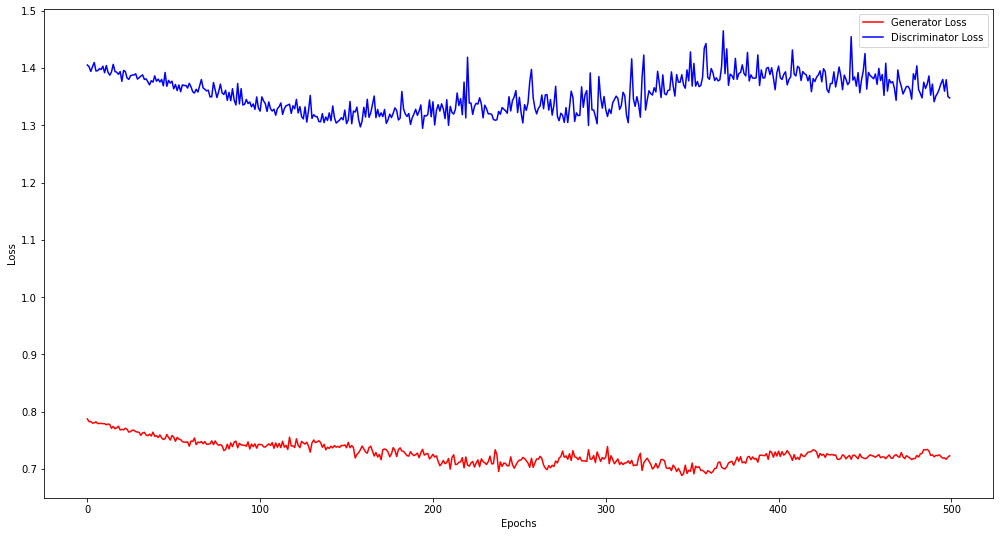

In [65]:
gen_net = Generator(z_dim = z_dim).to(device)
disc_net = Discriminator(image_size).to(device)

gan = GAN(dataloader = dataloader1, gen_net = gen_net, disc_net = disc_net, z_dim = z_dim, image_size = image_size, 
            batch_size = batch_size, lrG = lrG, lrD = lrD, gen_loss = loss, disc_loss = loss)


gan.learn(epochs)